In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import math

# Google Drive 마운트해서 데이터셋 가져옴

In [2]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


# root dir 
# data_root_dir
# train_data_root_dir
# test_data_root_dir 

In [3]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID-19_Radiography')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

# Google Drive 에서 dataset download

In [4]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'COVID-19_Radiography.zip'), '/content')

except Exception as err:
    print(str(err))

In [5]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
    
    shutil.rmtree(DATA_ROOT_DIR)
    
    print(DATA_ROOT_DIR + ' is removed !!!')

In [6]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID-19_Radiography.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

# 압축을 풀면 /content/COVID-19_Radiography/COVID-19_Radiography_Dataset/label_names 처럼 분류 정답을 나타내는 4개의 디렉토리가 있음. 또한 각각의 label_names 디렉토리에는 classification 위한 images 디렉토리와 segmentation 위한 mask 디렉토리가 있는데. 현재 예제에서는 classification 목적이므로 label_names/images 디렉토리만 /content/COVID-19_Radiography/train/label_names copytree 이용해서 복사함.
### 이때, train 디렉토리는 자동으로 생성됨 (미리 생성하면 copytree 사용법상 error 발생)

In [7]:
import shutil
import os
import glob

#========================================================
# 전체 파일 확인 (디렉토리와 일부 파일 혼재하고 있음)
# isfile(), isdir() 사용하기 위해서는 full_path를 사용해야 하므로
# os.listdir() 대신에 glob.glob() 사용함
#========================================================

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/*'))

print(total_file_list)    

#========================================================
# 정답 리스트 추출 (디렉토리 이름이 정답임)
#========================================================

label_name_list = [ file_name.split('/')[-1].strip()  for file_name in total_file_list  if os.path.isdir(file_name) == True ]

print(label_name_list)

#========================================================
# copytree 이용해서 정답이름/images 디렉토리를 
# train/정답이름 으로 복사함
#========================================================

for label_name in label_name_list:

    src_dir_path = os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset'+'/'+label_name+'/images')
    dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train'+'/'+label_name)

    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name+' copytree is done !!')

    except Exception as err:
        print(str(err))

['/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Viral Pneumonia', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Lung_Opacity', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/COVID.metadata.xlsx', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/COVID', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Normal', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/README.md.txt', '/content/COVID-19_Radiography/COVID-19_Radiography_Dataset/Normal.metadata.xlsx']
['Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Normal']
Viral Pneumonia copytree is done !!
Lung_Opacity copytree is done !!
COVID copytree is done !!
Normal copytree is done !!


In [8]:
import os

#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Normal']
train label :  Viral Pneumonia  =>  1345
train label :  Lung_Opacity  =>  6012
train label :  COVID  =>  3616
train label :  Normal  =>  10192


# covid_19_radiography/test 디렉토리 생성
# covid_19_radiography/test/하위 디렉토리 생성

In [9]:
#==============================================================
# test dir 생성
#==============================================================
if not os.path.exists(TEST_DATA_ROOT_DIR):

    os.mkdir(TEST_DATA_ROOT_DIR)
    print(TEST_DATA_ROOT_DIR + ' is created !!')
    
else:
    print(TEST_DATA_ROOT_DIR + ' already exists')
#==============================================================


#==============================================================
# test dir 하위디렉토리에 정답 디렉토리 생성
#==============================================================

for label_name in label_name_list:

    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):

        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))
        print(os.path.join(TEST_DATA_ROOT_DIR, label_name) + ' is created !!')

    else:
        print(os.path.join(TEST_DATA_ROOT_DIR, label_name) + ' already exists')

/content/COVID-19_Radiography/test is created !!
/content/COVID-19_Radiography/test/Viral Pneumonia is created !!
/content/COVID-19_Radiography/test/Lung_Opacity is created !!
/content/COVID-19_Radiography/test/COVID is created !!
/content/COVID-19_Radiography/test/Normal is created !!


# move 비율 설정

In [10]:
# 파일 move 비율

MOVE_RATIO = 0.2  # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

# 각각의 정답별로 원하는 비율만큼 train -> test  move   


In [11]:
import os
import glob
import shutil
import random

# 파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:

    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR,label_name)  
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR,label_name)  
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)

    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,len(train_data_file_list)))

    # data shuffle
    random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))

    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0

    for test_data_file in test_data_file_list:

        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))   
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

total [Viral Pneumonia] data file nums => [1345]
train data shuffle is done !!!
split nums =>  269
total move nums =>  269
total [Lung_Opacity] data file nums => [6012]
train data shuffle is done !!!
split nums =>  1202
total move nums =>  1202
total [COVID] data file nums => [3616]
train data shuffle is done !!!
split nums =>  723
total move nums =>  723
total [Normal] data file nums => [10192]
train data shuffle is done !!!
split nums =>  2038
total move nums =>  2038


# train/* 파일 개수 확인
# test/* 파일 개수 확인

In [12]:
import os

#==============================================================================
# train 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================


#==============================================================================
# test 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    print('test label : ' + label_name + ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================

['Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Normal']
train label : Viral Pneumonia =>  1076
train label : Lung_Opacity =>  4810
train label : COVID =>  2893
train label : Normal =>  8154
['Viral Pneumonia', 'Lung_Opacity', 'COVID', 'Normal']
test label : Viral Pneumonia =>  269
test label : Lung_Opacity =>  1202
test label : COVID =>  723
test label : Normal =>  2038


# 이미지 shape 설정

In [13]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# ImageDataGenerator 이용하여 데이터 불러옴

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) 

validation_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='training')


validation_generator = validation_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='validation')


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [16]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
4


# 32개 데이터 가져와서 16 개의 데이터와 정답 출력

In [17]:
IMG_NUMS = 16

image_data, image_label = train_generator.next()

data = image_data[:IMG_NUMS]

label = image_label[:IMG_NUMS]

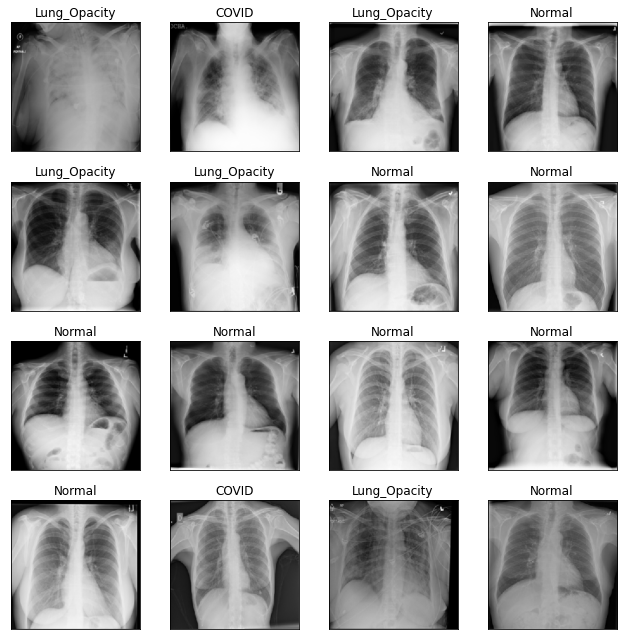

In [18]:
import matplotlib.pyplot as plt

class_dict = {0:'COVID', 1:'Lung_Opacity', 2:'Normal', 3:'Viral Pneumonia'}

plt.figure(figsize=(9,9))

for i in range(len(label)):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.tight_layout()
plt.show()

# Fine Tuning 위한 pre-trained model 정의 및 모델 구축

In [19]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

pre_trained_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [20]:
class_nums = train_generator.num_classes 

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))  # 0.25 오버피팅 발생함
model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
Non-

In [21]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

save_file_name = './COVID-19_Radiography_MobileNet_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,             # file명을 지정
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출
                             verbose=1,            # 로그를 출력
                             save_best_only=True,  # 가장 best 값만 저장
                             mode='auto'           # auto는 알아서 best를 찾음. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,        # 3회 Epoch동안 개선되지 않는다면 종료
                              verbose=1
                             )



start_time = datetime.now()

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/20
424/424 [==============================] - 160s 342ms/step - loss: 0.7566 - acc: 0.7135 - val_loss: 0.3800 - val_acc: 0.8721
Epoch 2/20
424/424 [==============================] - 145s 341ms/step - loss: 0.3726 - acc: 0.8705 - val_loss: 0.2305 - val_acc: 0.9191
Epoch 3/20
424/424 [==============================] - 145s 342ms/step - loss: 0.2681 - acc: 0.9084 - val_loss: 0.2003 - val_acc: 0.9288
Epoch 4/20
424/424 [==============================] - 145s 342ms/step - loss: 0.2134 - acc: 0.9269 - val_loss: 0.1879 - val_acc: 0.9350
Epoch 5/20
424/424 [==============================] - 145s 343ms/step - loss: 0.1780 - acc: 0.9395 - val_loss: 0.1816 - val_acc: 0.9353
Epoch 6/20
424/424 [==============================] - 145s 342ms/step - loss: 0.1439 - acc: 0.9492 - val_loss: 0.1726 - val_acc: 0.9412
Epoch 7/20
424/424 [==============================] - 146s 343ms/step - loss: 0.1149 - acc: 0.9601 - val_loss: 0.1740 - val_acc: 0.9439
Epoch 8/20
424/424 [============================

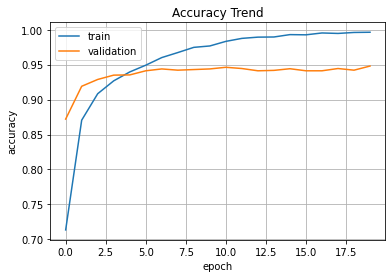

In [23]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

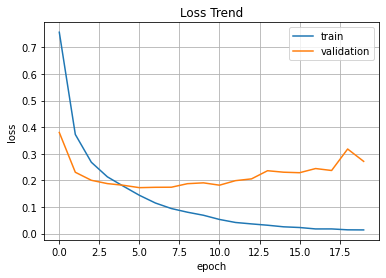

In [24]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [25]:
model.evaluate(test_generator)

133/133 [==============================] - 15s 110ms/step - loss: 0.3434 - acc: 0.9329


[0.34339311718940735, 0.9328922629356384]